#Gather candidate scores

In [1]:
import sys
sys.path.append('/home/flipvanrijn/Workspace/Dedicon-Thesis/server/pycocoevalcap')
from cider.cider import Cider
import numpy as np
import cPickle as pkl
from collections import OrderedDict
import re
from PIL import Image

In [2]:
def calc_scores(hyps_file, refs_file, scorer):
    with open(hyps_file) as hf, open(refs_file) as rf:
        hyps = {idx: [lines.strip()] for (idx, lines) in enumerate(hf)}
        refs = {idx: lines.strip().split('<>') for (idx, lines) in enumerate(rf)}
    _, scores = scorer.compute_score(refs, hyps)
    return scores, hyps

### Reduce full refs size

In [3]:
refs_full_file = '/media/Data/flipvanrijn/models/references_full_dev.txt'
refs_reduced_file = '/media/Data/flipvanrijn/models/references_dev.txt'
full_pointer = 0
reduced_pointer = 0
with open(refs_full_file) as rff, open(refs_reduced_file) as rrf:
    refs_full = [lines.strip() for lines in rff]
    refs_reduced = [lines.strip() for lines in rrf]

full_idxs = []
while reduced_pointer < len(refs_reduced):
    if refs_full[full_pointer] == refs_reduced[reduced_pointer]:
        full_idxs.append(full_pointer)
        full_pointer += 1
        reduced_pointer += 1
    else:
        full_pointer += 1

### Compute scores for the baseline

In [4]:
hyps_file = '/media/Data/flipvanrijn/models/baseline.npz.dev.hypotheses.txt'
refs_file = '/media/Data/flipvanrijn/models/references_full_dev.txt'
scores_baseline, hyps_baseline = calc_scores(hyps_file, refs_file, Cider())

In [5]:
scores_baseline_reduced = scores_baseline[full_idxs]
hyps_baseline_reduced = [hyp for i, hyp in hyps_baseline.items() if i in full_idxs]

### Compute scores for the context model

In [200]:
hyps_file = '/media/Data/flipvanrijn/models/context_att_w2v2ngramplus.npz.hypotheses.txt'
refs_file = '/media/Data/flipvanrijn/models/references_dev.txt'
scores_improved, hyps_improved = calc_scores(hyps_file, refs_file, Cider())

### Compare scores

In [26]:
better = np.where(scores_improved > scores_baseline_reduced)[0]
worse  = np.where(scores_improved < scores_baseline_reduced)[0]
print 'Better: ', (1.0*len(better) / len(hyps_improved)) * 100, 'Worse: ', (1.0*len(worse) / len(hyps_improved)) * 100

Better:  60.0411522634 Worse:  39.9588477366


In [27]:
difference = scores_improved - scores_baseline_reduced
np.argsort(difference)[::-1][:20]

array([3901, 3431, 1269, 3027,  890, 1793, 2042, 1600, 1222, 2557,  616,
       4237, 1928,  430, 4525, 2485, 3708,  165,   42,  105])

In [15]:
with open('/media/Data/flipvanrijn/datasets/coco/processed/reduced/coco_val_context.pkl') as f:
    titles = pkl.load(f)
    descriptions = pkl.load(f)
    tags = pkl.load(f)
    
featdict = OrderedDict()
idx = 0
with open('/media/Data/flipvanrijn/datasets/coco/processed/reduced/val2014list.txt', 'r') as f: #    ls val > val2014list.txt
    for line in f:
        line = re.sub(r'\/.*\/','',line).strip()
        featdict[line] = idx
        idx += 1
split = []
with open('/media/Data/flipvanrijn/datasets/coco/processed/reduced/splits/coco_val.txt', 'r') as f:
    for idx, line in enumerate(f):
        split.append(line.strip())

GTs:  a few people are skate boarding in a skate park .<>a guy on a skateboard in a skate park .<>skateboarders skateboard over ramps at a skate park underneath an underpass .<>a person on a skateboard in a skate park .<>an outdoor skate park with ramps underneath an overpass
Baseline:  ['a person standing in a hangar with a plane in the background .']
Improved:  ['a person is riding a skateboard in a skate park .']
Diff:  3.99275987
----------------------------------------------------------------------------------------------------
Context:  dude on rollerskates ! ! killing it burnside skate park sent from my stoopid iphone [u'onthego', u'burnside', u'portland', u'skatepark', u'skateboard', u'rollerskate']


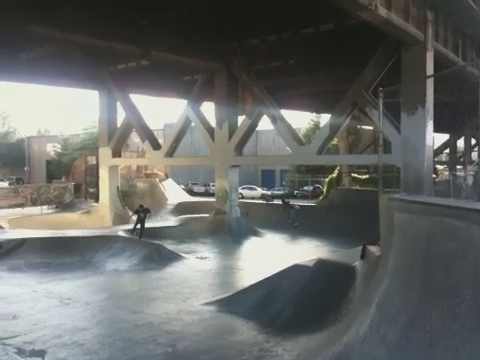

In [28]:
idx = 3901
print 'GTs: ', refs_reduced[idx]
print 'Baseline: ', hyps_baseline_reduced[idx]
print 'Improved: ', hyps_improved[idx]
print 'Diff: ', difference[idx]
print '-'*100
print 'Context: ', titles[featdict[split[idx]]], descriptions[featdict[split[idx]]], tags[featdict[split[idx]]]
Image.open('/media/Data/flipvanrijn/datasets/coco/images/val/' + split[idx])

In [60]:
lens_tfidf = [len(h[0].split(' ')) for h in hyps_improved.values()]

In [63]:
lens_raw = [len(h[0].split(' ')) for h in hyps_improved.values()]

In [72]:
lens_tfidf_lsa = [len(h[0].split(' ')) for h in hyps_improved.values()]

In [77]:
lens_tfidf_stemming = [len(h[0].split(' ')) for h in hyps_improved.values()]

In [80]:
lens_w2v1n = [len(h[0].split(' ')) for h in hyps_improved.values()]

In [83]:
lens_w2v2n = [len(h[0].split(' ')) for h in hyps_improved.values()]

In [85]:
lens_w2v3n = [len(h[0].split(' ')) for h in hyps_improved.values()]

In [88]:
lens_w2vtfidf = [len(h[0].split(' ')) for h in hyps_improved.values()]

In [201]:
lens_w2v2nplus = [len(h[0].split(' ')) for h in hyps_improved.values()]

In [206]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams.update({'font.size': 12})
#pal = sb.color_palette('hls', n_colors=9)
#sb.set_palette(pal, n_colors=9)

lens_baseline = [len(h[0].split(' ')) for h in hyps_baseline_reduced]

# TF-IDF
#plt.hist([lens_tfidf, lens_tfidf_lsa, lens_tfidf_stemming, lens_baseline],  25, range=(0, 26), align='mid',
#         label=['TF-IDF', 'TF-IDF w/o LSA', 'TF-IDF w/o stemming', 'Baseline'])
# W2V
plt.hist([lens_w2v1n, lens_w2v2n, lens_w2v2nplus, lens_w2v3n, lens_baseline], 25, range=(0, 25), align='mid',
        label=[r'Word2Vec n=1 $\odot$', r'Word2Vec n=2 $\odot$', r'Word2Vec n=2 $\oplus$', r'Word2Vec n=3 $\odot$', 'Baseline'])
# Raw
#plt.hist([lens_raw, lens_baseline], 25, range=(0,25), align='mid', label=['Raw', 'Baseline'])
plt.legend(loc='upper right')
#plt.xlim([5, 25])
plt.xlabel('Sentence length (in words)')
plt.ylabel('Frequency (in sentences)')
plt.title('Distribution generated sentence lengths Word2Vec vs baseline')
plt.show()

In [173]:
max_ = max(set(lens_w2v1n))
min_ = min(set(lens_w2v1n))
plt.hist([lens_w2v1n, lens_baseline], max_ - min_, range=(min_, max_))
plt.show()

In [218]:
from scipy.stats import ks_2samp, ttest_ind
#r = ks_2samp(lens_tfidf_stemming, lens_w2v2n)
t, p = ttest_ind(lens_w2v2n, lens_w2v2nplus)
print t, p

-9.55079277679 1.59958306599e-21
